# DataOrtho Sagittal 

Sagittal Subset Modeling Notebook


In [30]:
import os
import numpy as np
import json
import datetime
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  Callback,ModelCheckpoint,TensorBoard, EarlyStopping # ,LearningRateScheduler - using dynamic one

print('tf:',tf.__version__)
print('tfa:',tfa.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print('GPU devices: ',gpus)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available.")

tf: 2.10.0
tfa: 0.20.0
GPU devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


### Vars and Paths

In [2]:
# Paths
resampled_dir  = 'C:/Users/Eduardo/Desktop/DataOrtho_Resampled/'
tfrecords_dir = 'C:/Users/Eduardo/Desktop/DataOrtho_Serialized/'
logs_dir = 'C:/Users/Eduardo/Desktop/dataortho_edu/logs/' 

# Cross validation vars
fold_idx = 1
n_folds = 5

# Training parameters
params = {'augment':False,
          'mode': tf.estimator.ModeKeys.TRAIN, 
          'seed':42,
          'subset':'DATASET_SAGITTAL',
          'interpolation':'Linear Interpolation',
          'normalization': 'batchnorm',#'batchnorm',
          'total_train_samples':0, # value attributed in dataset_split
          'total_val_samples':0,   # value attributed in dataset_split
          'lr': 0.0001, # 0.001 de forma a ver
          'loss':'dice+ce',
          'dropout':0.2,
          'batch_size':2,
          'norm_params_minmax':None, #(0.0, 3893.436),
          'norm_params_meanstd':None
          }
# Direct vars
batch_size = 2
seed = 42 

#Numver of channel for each subset
num_channels = {'DATASET_AXIAL': 12,'DATASET_SAGITTAL':8,'DATASET_DYNAMIC':19}

# Data Shapes (Before batching) 
xshape =  {'DATASET_AXIAL': (32,256, 256,1), 'DATASET_SAGITTAL': (32,256, 256,1),'DATASET_DYNAMIC': (64,256, 256,1)}
yshape = {'DATASET_AXIAL': (32,256, 256,12), 'DATASET_SAGITTAL': (32,256, 256,8),'DATASET_DYNAMIC': (64, 256, 256, 19)}
input_shape={'DATASET_AXIAL': (32,256, 256,1), 'DATASET_SAGITTAL': (32,256, 256,1),'DATASET_DYNAMIC': (64,256, 256,1)}

# test subset individuals 
test_subjects = {'DATASET_SAGITTAL': [5, 20, 23, 34, 45, 54, 64, 70, 75, 81, 12, 13, 38, 42, 44, 49, 62, 68]}

# landmark Subset Classes
landmarkClasses = {'DATASET_SAGITTAL':
                       {0:'S0',
                        1:'S1', 
                        2:'S2', 
                        3:'S3', 
                        4:'S4', 
                        5:'S5', 
                        6:'S6', 
                        7:'SB' }}

### Help Functions

- 4D (channels dimension) Visualization 
- Help functions for Data augmentation Visualization
- Help functions for Evaluation Visualization
- String path refactor for Windows

In [3]:
def visualize_montage_mri_4D_channel(mri_volume,heatmaps_masks,channel, start_slice, end_slice, step=1):
    num_landmarks = heatmaps_masks.shape[-1] 
    
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(20, 5*num_landmarks))
    
    max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), heatmaps_masks[..., channel].shape)
    
    print('Intensity masks: ', heatmaps_masks[max_intensity_idx[0],max_intensity_idx[1],max_intensity_idx[2], channel])
    print('Intensity volume: ', mri_volume[max_intensity_idx[0],max_intensity_idx[1],max_intensity_idx[2], 0])

    print(f"Channel {channel} has maximum intensity at slice: {max_intensity_idx[0]}")
    max_intensity = np.argmax(heatmaps_masks[..., channel])
    print('max: ', max_intensity)
    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[idx,:], cmap='gray') 
        axarr[i].imshow(heatmaps_masks[idx,:, :,channel], cmap='jet', alpha=0.5,vmin = 0, vmax=1)  # specific landmark heatmap overlay
        axarr[i].axis('off')
        if i == 0:
            if channel == num_landmarks - 1:
                axarr[i].set_ylabel(f'Background')
            else:
                axarr[i].set_ylabel(f'Landmark {channel + 1}')
            
        axarr[i].set_title(f'Slice: {idx}')
        
    plt.tight_layout()
    plt.show()
    
def visualize_specific_slice_4Dmask(slice_idx,channel,mri_volume, heatmaps_channel):
    fig, axarr = plt.subplots(1, figsize=(16, 8))
    axarr.imshow(mri_volume[slice_idx,:,:],cmap='gray')
    axarr.imshow(heatmaps_channel[slice_idx,:, :,  channel], cmap='jet', alpha=0.5,vmin = 0, vmax=1)
    axarr.set_title(f'Slice: {slice_idx}')
    plt.show()


#---------- Help functions for Data augmentation Visualization ----------#
# Function to visualize a single slice
def visualize_slice(volume_slice, mask_slice=None, cmap='gray'):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(volume_slice, cmap=cmap)
    plt.title('Volume Slice')
    plt.axis('off')
    
    if mask_slice is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(mask_slice, cmap=cmap)
        plt.title('Mask Slice')
        plt.axis('off')
    
    plt.show()

#---------- Help functions for Evaluation Visualization ----------#

def visualize_learning_curves(epochs,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# not needed in ubuntu
def refactor_path(path_example):
    return path_example.replace("\\", "/")

# returns the maximum intensity for each channel slice 
def analyze_heatmaps_predictions(heatmaps_masks,subset):
    num_channels = heatmaps_masks.shape[-1] # Number of landmarks (channels)
    max_intensity_slices = []
    landmarksNames = landmarkClasses[subset]
    for channel in range(num_channels):
        # Find the index of maximum intensity in the channel
        max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), 
                                             heatmaps_masks[..., channel].shape)
        # Get the slice number (depth) with maximum intensity
        slice_with_max_intensity = max_intensity_idx[0]

        max_intensity_slices.append((channel, slice_with_max_intensity))
    
    for channel, slice_idx in max_intensity_slices:
        print(f"Landmark {landmarksNames[channel]} has maximum intensity at slice: {slice_idx}")
    #return max_intensity_slices

## Data Augmentation procedures

### 3D procedures from Architecture were analysed and used as base for the following:

- random_horizontal_flip()
- random_rotate_3d() 
- random_translate_3d() : 2D only
- blur()
- noising()


#### **Validated**
- Random Horizontal Flip 3D : Sagittal needed? - tf.image.flip_up_down
- Random Rotate 3D 
- Random Translate 3D
- Blur 
- Noising

**process_augmentation** - main Augmentation function

In [4]:
# testar para sagittal - 0.5 threshold
def random_horizontal_flip(samples, labels, threshold=0.3):
    h_flip = tf.random.uniform([]) > threshold 
    def hflip_volume(volume):
        return tf.image.flip_left_right(volume)

    samples = tf.cond(h_flip, lambda: hflip_volume(samples), lambda: samples)
    labels = tf.cond(h_flip, lambda: hflip_volume(labels), lambda: labels)
    return samples, labels

# rotate
def random_rotate_3d(samples,labels,n_channels_samples,n_channels_labels,angle_range=(-0.7,0.7)):
    angle = tf.random.uniform([], minval=angle_range[0], maxval=angle_range[1])
    perform_augmentation = tf.random.uniform([]) > 0.1
    samples = tf.cond(perform_augmentation, lambda: rotate_volume(samples, angle,n_channels_samples), lambda: samples)
    labels = tf.cond(perform_augmentation, lambda: rotate_volume(labels, angle,n_channels_labels), lambda: labels)
    return samples, labels


def rotate_volume(volume,angle,n_channels):
    def rotate_slice(slice):
        # ensure the number of channels is known
        # angle comes from higher lvl fnction
        rotated_channels = [tfa.image.rotate(slice[:, :, c], angle) for c in range(n_channels)]
        return tf.stack(rotated_channels, axis=-1)
    # Apply the rotation to each slice in the volume or mask
    rotated_volume = tf.map_fn(rotate_slice, volume, dtype=volume.dtype)
    return rotated_volume

# translate
def random_translate_3d(samples, labels,n_slices,n_channels_samples,n_channels_labels, threshold=10):
    perform_augmentation = tf.random.uniform([]) > 0.1# type: ignore
    translations = tf.random.uniform([2], minval=-threshold, maxval=threshold)
    samples = tf.cond(perform_augmentation, lambda: translate_volume(samples, translations,n_slices,n_channels_samples), lambda: samples) 
    labels = tf.cond(perform_augmentation, lambda: translate_volume(labels, translations,n_slices,n_channels_labels), lambda: labels)
    return samples, labels


def translate_volume(volume, translations,n_slices, n_channels):
    # We will collect the translated slices in this list.
    translated_slices = []

    # Loop over the depth dimension and translate each 2D slice.
    for i in range(n_slices):
        if n_channels == 1:
            # Translate the 2D slice and keep the channel dimension as the last dimension.
            slice_2d = volume[i, :, :, 0]  # Extract the 2D slice.
            translated_slice = tfa.image.translate(slice_2d, translations)
            translated_slice = tf.expand_dims(translated_slice, axis=-1)  # Add the channel dimension back.
        else:
            # Translate the 2D slice for each channel.
            slice_3d = volume[i, :, :, :]  # Extract the 3D slice (depth,height, width, channels).
            translated_slice = [tfa.image.translate(slice_3d[:, :, c], translations) for c in range(n_channels)]
            translated_slice = tf.stack(translated_slice, axis=-1)

        # append the translated slice to the list.
        translated_slices.append(translated_slice)

    # stack the translated slices along the depth dimension.
    translated_volume = tf.stack(translated_slices, axis=0)
    
    return translated_volume

def blur(samples, labels, sigma=2.0):
    def blur_slice(slice):
        return tfa.image.gaussian_filter2d(slice, sigma=sigma)
    
    perform_blurring = tf.random.uniform([]) > 0.2 # type: ignore
    blurred_samples = tf.cond(perform_blurring,
                              lambda: tf.map_fn(blur_slice, samples, dtype=samples.dtype),
                              lambda: samples)
    return blurred_samples, labels
    #blurred_samples = tf.map_fn(lambda slice: tfa.image.gaussian_filter2d(slice, sigma=sigma), samples, dtype=samples.dtype)
    #return blurred_samples, labels

def noising(samples, labels, mean=0.0, stddev=0.01):
    perform_noising = tf.random.uniform([]) > 0.1 # type: ignore
    noise = tf.random.normal(shape=tf.shape(samples), mean=mean, stddev=stddev)
    noised_samples = tf.cond(perform_noising,
                            lambda: samples + noise,
                            lambda: samples)
    return noised_samples, labels


def process_augmentation(samples,labels):
    samples,labels = random_rotate_3d(samples,labels,xshape[params['subset']][-1],yshape[params['subset']][-1])
    # samples, labels = random_horizontal_flip(samples, labels,threshold=0.5)
    samples, labels = random_translate_3d(samples, labels,xshape[params['subset']][0],xshape[params['subset']][-1],yshape[params['subset']][-1])
    samples, labels = blur(samples, labels)
    samples, labels = noising(samples, labels)
    return samples, labels

#### **Not Validated** - Zoom 3D 

In [7]:
def zoom_3d(samples, labels, xshape, yshape, zoom_range=(0.8, 1.6)):
    zoom_factor = tf.random.uniform([], minval=zoom_range[0], maxval=zoom_range[1])

    # Define the zoom function for a single 2D slice
    def zoom_slice(slice_2d, zoom_factor, output_size):
        # Add a channel dimension to slice_2d if it doesn't have it
        if len(slice_2d.shape) == 2:
            slice_2d = tf.expand_dims(slice_2d, axis=-1)
        
        new_size = tf.cast(tf.cast(tf.shape(slice_2d)[:2], tf.float32) * zoom_factor, tf.int32)
        resized_slice = tf.image.resize(slice_2d, new_size)
        # Resize back to the output size and remove the added channel dimension if it was not originally present
        resized_slice = tf.image.resize(resized_slice, output_size)
        if resized_slice.shape[-1] == 1:
            resized_slice = tf.squeeze(resized_slice, axis=-1)
        return resized_slice

    # Apply the zoom to each slice for samples
    zoomed_samples = tf.map_fn(
        lambda slc: zoom_slice(slc, zoom_factor, xshape[:2]), 
        samples, 
        dtype=samples.dtype
    )

    # Apply the zoom to each slice for labels, handling each channel separately
    if labels is not None:
        def zoom_label_slices(label_3d):
            return tf.map_fn(
                lambda slc: zoom_slice(slc, zoom_factor, yshape[:2]), 
                label_3d, 
                dtype=labels.dtype
            )
        zoomed_labels = tf.map_fn(
            zoom_label_slices, 
            labels, 
            dtype=labels.dtype
        )

    # Set the shapes to match the target shapes
    zoomed_samples.set_shape(xshape)
    if labels is not None:
        zoomed_labels.set_shape(yshape)

    return zoomed_samples, zoomed_labels

## Data Input and processing - TFRecords format

### Input, Load and Normalization
 - mean and standard deviation calculation for normalization.
 - type 0 normalization with min and max
 - type 1 or else for normalization with mean and stddev

In [5]:
def parse_tfrecord(serialized_sequence):
    feature_description = {
        'volume': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }

    sequence = tf.io.parse_single_example(serialized_sequence,feature_description)
    volume = tf.io.parse_tensor(sequence['volume'], out_type=tf.float32)
    mask = tf.io.parse_tensor(sequence['mask'], out_type=tf.float32)
    return volume,mask


def get_norm_params(tfrecords_paths, norm_type=0):
    dataset = tf.data.TFRecordDataset(tfrecords_paths)
    dataset = dataset.map(parse_tfrecord,num_parallel_calls=tf.data.experimental.AUTOTUNE)

    global_min = tf.constant(float('inf'), tf.float32)
    global_max = tf.constant(float('-inf'), tf.float32)

    for vol, _ in dataset:
        batch_min = tf.reduce_min(vol)
        batch_max = tf.reduce_max(vol)
        
        global_min = tf.reduce_min([global_min, batch_min])
        global_max = tf.reduce_max([global_max, batch_max])
    
    # Convert TensorFlow tensors to numpy values before returning
    return global_min.numpy(), global_max.numpy()


def tf_min_max_normalize(volume, min_val, max_val):
    return (volume - min_val) / (max_val - min_val)

def tf_standard_normalize(volume, mean, std):
    return (volume - mean) / std

# load tfrecords function 
def load_tfr_dataset(tfrecords_paths, normalization_params, norm_type=0):
    dataset = tf.data.TFRecordDataset(tfrecords_paths)
    dataset = dataset.map(parse_tfrecord,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if norm_type == 0:
        _min, _max = normalization_params
        dataset = dataset.map(lambda volume_file, mask_file: (tf_min_max_normalize(volume_file,_min,_max),mask_file))
            
    else:
        mean, std = normalization_params            
        dataset = dataset.map(
            lambda volume_file, mask_file: (tf_standard_normalize(volume_file, mean, std), mask_file))
    
    volume_shape = xshape[params['subset']]
    mask_shape = yshape[params['subset']]

    dataset = dataset.map(lambda volume, mask: (tf.ensure_shape(volume, volume_shape),
                                                tf.ensure_shape(mask, mask_shape)))
    return dataset

def parse_test_tfrecords(data_dir,test_subjects):
    sequence_files = []
     
    for individual in os.listdir(data_dir):
        if int(individual) in test_subjects:
            individual_sequence = os.path.join(data_dir, individual)
            for knee in os.listdir(individual_sequence):
                    knee_sequence = os.path.join(individual_sequence, knee)
                    for sequence in os.listdir(knee_sequence):
                        sequence_path = os.path.join(knee_sequence, sequence)
                        file_path = os.path.join(sequence_path, sequence + '.tfrecord')
                        sequence_files.append(file_path)

    return sequence_files

def load_tfr_subject_test(subject_path,normalization_params,norm_type=0):
    data = tf.data.TFRecordDataset(subject_path)
    data = data.map(parse_tfrecord,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if norm_type == 0:
        _min, _max = normalization_params
        data = data.map(lambda volume_file, mask_file: (tf_min_max_normalize(volume_file,_min,_max),mask_file))
            
    else:
        mean, std = normalization_params            
        dataset = data.map(
            lambda volume_file, mask_file: (tf_standard_normalize(volume_file, mean, std), mask_file))
    
    volume_shape = xshape[params['subset']]
    mask_shape = yshape[params['subset']]
    data = data.map(lambda vol, mask: (tf.ensure_shape(vol,volume_shape),
                                       tf.ensure_shape(mask,mask_shape)))
    # input dimension for predict call is 5D
    data = data.batch(1)
    return data

# List of tuples, where each tuple contains the path to a volume file and its corresponding mask file.
def create_subject_tfrpaths(subset_dir,test_subjects):
    sequence_files = []

    for individual in os.listdir(subset_dir):
        if int(individual) not in test_subjects:
            individual_sequences = os.path.join(subset_dir, individual) 
            for knee in os.listdir(individual_sequences):
                knee_sequences = os.path.join(individual_sequences, knee)
                for sequence in os.listdir(knee_sequences):
                    sequence_file = os.path.join(knee_sequences, sequence,sequence + '.tfrecord')
                    sequence_files.append(sequence_file)
                         
    return sequence_files

def subset_cross_validation_tfr(subset_dir, test_subjects,fold_idx, n_folds):
    # get all subject paths
    tfrecords_paths = create_subject_tfrpaths(subset_dir,test_subjects)
    # convert to numpy array for easy manipulation
    
    # perform cross-validation
    kf = KFold(n_splits=n_folds)
    folds = list(kf.split(tfrecords_paths))
    
    # get the current fold data
    train_indices, val_indices = folds[fold_idx]
    train_paths = [tfrecords_paths[i] for i in train_indices]
    val_paths = [tfrecords_paths[i] for i in val_indices]

    return train_paths, val_paths

In [6]:
def train_tfr_fn(subject_paths,normalization_params_train,norm_type,batch_size,seed,params):
        """ Create dataset for training """
        dataset = load_tfr_dataset(subject_paths,normalization_params_train,norm_type)

        if params['augment']:
            dataset = dataset.map(
                map_func=lambda x, y: process_augmentation(x, y),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
            )
        dataset = dataset.shuffle(100, seed)
        dataset = dataset.batch(batch_size,
                                drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset

def val_tfr_fn(val_paths,normalization_params,batch_size):
    """ Create dataset for Validation """
    dataset = load_tfr_dataset(val_paths, normalization_params)
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=False) # not
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


def test_tfr_fn(test_paths,normalization_params):
    """ Create dataset for Test"""
    dataset = load_tfr_dataset(test_paths, normalization_params)
    dataset = dataset.batch(1)
                            #drop_remainder=self.params.benchmark)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    #print_dataset_shapes(dataset)
    return dataset


def validate_dataset(filenames, reader_opts=None):
    """
    Attempt to iterate over every record in the supplied iterable of TFRecord filenames
    :param filenames: iterable of filenames to read
    :param reader_opts: (optional) tf.python_io.TFRecordOptions to use when constructing the record iterator
    """
    i = 0
    corrupts = []
    corrupt = 0
    for fname in filenames:
        #print('validating ', fname)
        record_iterator = tf.compat.v1.io.tf_record_iterator(path=fname, options=reader_opts)
        try:
            for _ in record_iterator:
                i += 1
        except Exception as e:
            print('error in {} at record {}'.format(fname, i))
            corrupt = 1
            corrupts.append(fname)
            print(e)
    
    return corrupt

def dataset_tfr_split():
    data_dir = os.path.join(tfrecords_dir,params['subset'])

    test_paths = parse_test_tfrecords(data_dir,test_subjects[params['subset']])
    # perform cross-validation on the paths that are valid for training,
    # subset_cross_validation must make sure that trains_paths and val_paths return without
    # any of the subject indicated on test_subjects list 
    train_paths, val_paths  = subset_cross_validation_tfr(data_dir, test_subjects[params['subset']], fold_idx, n_folds) #separate norm_params training and validation

    if params['norm_params_minmax']: 
        normalization_params_train = params['norm_params_minmax']
    else:
        normalization_params_train = get_norm_params(train_paths,0)
    print("Number of training tuple paths:", len(train_paths))
    print("Number of validation tuple paths:", len(val_paths))
    print("Number of test tuple paths:", len(test_paths))
    print("Normalization parameters training:", normalization_params_train)
    print("Fold id:",fold_idx)
    
    # defined for number of steps on the model fit
    params['total_train_samples'] = len(train_paths)
    params['total_val_samples'] =  len(val_paths)
    train_ds = None
    val_ds = None
    # create the train_ds input and tensorflow.python.data.ops.map_op._MapDataset Dataset
    if validate_dataset(train_paths) == 0:
        train_ds = train_tfr_fn(train_paths,normalization_params_train,0,batch_size,seed,params)
        val_ds = val_tfr_fn(val_paths,normalization_params_train,batch_size)
    
        return train_paths,val_paths,train_ds,val_ds, test_paths ,normalization_params_train
    else:
        print('Corrupted files')
        return train_paths,val_paths,train_ds,val_ds, test_paths ,normalization_params_train

        

#### Validate the tfrecords dataset

In [7]:
def parse_and_inspect_tfrecord(file_path):
    feature_description = {
        'volume': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    raw_dataset = tf.data.TFRecordDataset(file_path)
    for i, serialized_example in enumerate(raw_dataset):
        try:
            parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
            volume = tf.io.parse_tensor(parsed_example['volume'], out_type=tf.float32)
            mask = tf.io.parse_tensor(parsed_example['mask'], out_type=tf.float32)
            inspect_data(volume, f'Volume {i}')
            inspect_data(mask, f'Mask {i}')
        except Exception as e:
            print(f"Error parsing record {i}: {e}")
    
def inspect_data(data, label):
    print(f"Inspecting {label}:")
    print(f"Shape: {data.shape}, Dtype: {data.dtype}")
    print(f"Max: {np.max(data)}, Min: {np.min(data)}")
    print(f"NaNs: {np.isnan(data).sum()}, Infs: {np.isinf(data).sum()}")

def validate_tfrecord(file_path):
    raw_dataset = tf.data.TFRecordDataset(file_path)
    record_count = 0
    try:
        for raw_record in raw_dataset:
            record_count += 1
    except tf.errors.DataLossError as e:
        print(f"Error reading record {record_count}: {e}")
        return False
    print(f"All {record_count} records read successfully.")
    return True

def is_tfrecord_corrupted(tfrecord_file):
    try:
        for record in tf.data.TFRecordDataset(tfrecord_file):
            # Attempt to parse the record
            _ = tf.train.Example.FromString(record.numpy())
    except tf.errors.DataLossError as e:
        print(f"DataLossError encountered: {e}")
        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return True
    return False



In [16]:
parse_and_inspect_tfrecord(corrupt)
validate_dataset(train_paths)

Inspecting Volume 0:
Shape: (32, 256, 256, 1), Dtype: <dtype: 'float32'>
Max: 508.46875, Min: 0.0
NaNs: 0, Infs: 0
Inspecting Mask 0:
Shape: (32, 256, 256, 8), Dtype: <dtype: 'float32'>
Max: 1.0, Min: -0.7778438925743103
NaNs: 0, Infs: 0


In [28]:
validate_tfrecord(train_paths)

All 276 records read successfully.


True

## Architecture

### Architecture Layers

Methods based on basic 3D U-Net architecture [https://catalog.ngc.nvidia.com/orgs/nvidia/resources/unet3d_medical_for_tensorflow](https://)

#### <span style="color:lightblue"> Lower level methods </span>

Convolution, normalization and activation methods:
 - more control of the architecture
 - use of regularization (?): Kernel Initialiser: how the weights of the kernels are initially set before training begins

#### <span style="color:lightblue"> Higher Level methods </span>

Not using MaxPooling! The key difference between using strided convolutions and MaxPooling for downsampling is that strided convolutions involve learnable parameters and can learn to downsample in a more data-driven manner, whereas MaxPooling is a fixed operation that simply takes the maximum value over the pooling window.

By not applying normalization or activation immediately after upsampling, you allow the model to first merge these upsampled features with the skip connection features. This can be important because the skip connections carry high-resolution spatial information from the encoder, which can be more effectively integrated with the upsampled features before any further processing.

In [9]:
def _normalization(inputs, name, mode):
    training = mode == tf.estimator.ModeKeys.TRAIN
    if name == 'instancenorm':
        return tf.keras.layers.LayerNormalization(
            axis=[1, 2, 3],  # Normalizing across the spatial dimensions
            center=True,
            scale=True,
            epsilon=1e-6)(inputs)

    if name == 'groupnorm':
        return tfa.layers.GroupNormalization(
            groups=4,
            axis=-1,  # Channel axis
            epsilon=1e-5)(inputs)

    if name == 'batchnorm':
        return tf.keras.layers.BatchNormalization(axis=-1, #channels index is the last one
                                                  trainable=True,
                                                  virtual_batch_size=None)(inputs, training=training)
    if name == 'none':
        return inputs

    raise ValueError('Invalid normalization layer')


def _activation(out, activation):
    if activation == 'relu':
        return tf.keras.layers.ReLU()(out)
    if activation == 'leaky_relu':
        return tf.keras.layers.LeakyReLU(alpha=0.01)(out)
    if activation == 'sigmoid':
        return tf.keras.layers.Activation('sigmoid')(out)
    if activation == 'softmax':
        return tf.keras.layers.Activation('softmax')(out)
    if activation == 'none':
        return out

    raise ValueError("Unknown activation {}".format(activation))

def convolution(inputs,  
                out_channels,
                kernel_size=3,
                stride=1,
                mode=tf.estimator.ModeKeys.TRAIN,
                normalization='batchnorm',
                activation='relu',
                transpose=False):

    if transpose:
        conv = tf.keras.layers.Conv3DTranspose
    else:
        conv = tf.keras.layers.Conv3D
    regularizer = None #tf.keras.regularizers.l2(1e-5) # trying L2 Regularization

    use_bias = normalization == "none"
    inputs = conv(filters=out_channels,
                  kernel_size=kernel_size,
                  strides=stride,
                  activation=None,
                  padding='same',
                  data_format='channels_last',
                  kernel_initializer=tf.compat.v1.initializers.he_uniform(), # use HE with ReLU
                  kernel_regularizer=regularizer,
                  bias_initializer='zeros',
                  bias_regularizer=regularizer,
                  use_bias=use_bias)(inputs)
    
    # batch normalization before each activation
    inputs = _normalization(inputs, normalization, mode)
    #print(' Convolution INPUTS SHAPE',inputs.shape)
    return _activation(inputs, activation)


''' Padding and Cropping (Not currently used)'''
# if feature maps align perfectly, we dont need this method
def dynamic_crop_and_concat(up_conv,skip_feature):
    print('Skip feature before crop :',up_conv.shape)

    crop_size = [(up_conv.shape[i+1] - skip_feature.shape[i+1]) // 2 for i in range(3)]
    additional_crop = [(up_conv.shape[i+1] - skip_feature.shape[i+1]) % 2 for i in range(3)]
    crop_size = [(crop_size[i], crop_size[i] + additional_crop[i]) for i in range(3)]
    
    # Concatenate along the feature axis
    cropped_up_conv = tf.keras.layers.Cropping3D(cropping=crop_size)(up_conv)
    print('INPUT SHAPE cropped to CONCATENATE:',cropped_up_conv.shape,'Skip feature to CONCATENATE:',skip_feature.shape)

    return tf.keras.layers.Concatenate(axis=-1)([cropped_up_conv, skip_feature])

'''Encoding'''
# Input block
def input_block(inputs, out_channels, normalization, mode):
    #stride = 1 kernel_size= 3
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    print('Input shape input block with filter',out_channels,':',inputs.shape)
    return inputs

# Downsample with Residual blocks
def downsample_Residual_block(inputs, out_channels, normalization, mode):
    # Convolutional path
    #the next convolution imitates the maxpooling behaviour
    # offering additional benefits in feature learning and representation
    conv_path = convolution(inputs, out_channels=out_channels, normalization=normalization, 
                            mode=mode, stride=2)
    conv_path = convolution(conv_path, out_channels=out_channels, normalization=normalization, 
                            mode=mode)

    # Residual path modification adds a residual connection that includes a 1x1x1 
    # convolution with a stride of 2 to downsample the input before adding  it 
    # to the output of the convolutional layers within the block
    # previous kernel = 3
    residual_path = convolution(inputs, out_channels=out_channels, kernel_size=1, stride=2,
                                normalization=normalization, mode=mode, activation='none')
    
    # Add the residual connection
    out = tf.keras.layers.Add()([conv_path, residual_path])
    out = _activation(out, 'relu')

    return out

# classic U-Net
def downsample_block(inputs, out_channels, normalization, mode):
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode, stride=2)
    print('Input shape downsample block with filter',out_channels,':',inputs.shape)
    return convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)


'''Decoding'''

def attention_gate(inputs,attention,inter_channel):
    theta_x = tf.keras.layers.Conv3D(inter_channel,kernel_size=2,strides=2,padding='same')(inputs)
    phi_g = tf.keras.layers.Conv3D(inter_channel, kernel_size=1, padding='same')(attention)

    concat_xg = tf.keras.layers.Add()([theta_x, phi_g])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = tf.keras.layers.Conv3D(1, kernel_size=1, padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    
    upsample_psi = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(sigmoid_xg)
    scale_attention = tf.keras.layers.Multiply()([upsample_psi, inputs])

    return scale_attention

# Upsample with attention gates
def upsample_attention_block(inputs, skip_connection, out_channels, normalization, mode):
    # attention gate where we give special importance to features that are the most revelant
    attention = attention_gate(skip_connection,inputs,out_channels//2)
    inputs = convolution(inputs, kernel_size=3, out_channels=out_channels, stride=2,
                         normalization='none', activation='none', transpose=True)

    # Use dynamic crop and concat
    #inputs = dynamic_crop_and_concat(inputs, skip_connection)
    inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, attention])
    
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    print('Input shape AFTER concatenate:',inputs.shape)
    return inputs

# Upsample with residual block
def upsample_Residual_block(inputs, skip_connection, out_channels, normalization, mode, residual_kernel=1):
    main_path = convolution(inputs, kernel_size=3, out_channels=out_channels, stride=2,
                            normalization=normalization, activation='none', transpose=True)
    main_path = tf.keras.layers.Concatenate(axis=-1)([main_path, skip_connection])
    main_path = convolution(main_path, out_channels=out_channels, normalization=normalization, mode=mode)
    main_path = convolution(main_path, out_channels=out_channels, normalization=normalization, mode=mode)

    # Residual path: Transposed convolution (or another upsampling technique) to match the dimensions
    residual_path = convolution(inputs, out_channels=out_channels, kernel_size=residual_kernel, stride=2,
                                normalization=normalization, mode=mode, activation='none', transpose=True)
    

 
    #residual_path = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(inputs)
    #residual_path = convolution(residual_path, out_channels=out_channels, kernel_size=1, normalization=normalization, mode=mode)

    # Add the residual connection
    out = tf.keras.layers.Add()([main_path, residual_path])
    out = _activation(out, 'relu')
    return out

# Upsample Layer with Residual block and attention gates
def upsample_ResidualAttention_block(inputs, skip_connection,out_channels,normalization,mode):

    attention = attention_gate(skip_connection,inputs,out_channels//2)

    upsampled = convolution(inputs, kernel_size=3, out_channels=out_channels, stride=2,
                         normalization='none', activation='none', transpose=True)
    
    concat = tf.keras.layers.Concatenate(axis=-1)([upsampled, attention])

    # Convolutional path
    conv_path = convolution(concat, out_channels=out_channels, normalization=normalization, mode=mode)
    conv_path = convolution(conv_path, out_channels=out_channels, normalization=normalization, mode=mode)

    residual_path = convolution(inputs, out_channels=out_channels, kernel_size=1, stride=2,
                                normalization=normalization, mode=mode, activation='none', transpose=True)
    
    out = tf.keras.layers.Add()([conv_path, residual_path])
    out = _activation(out, 'relu')
    return out

# normal 3D U-Net upsample block
def upsample_block(inputs, skip_connection, out_channels, normalization, mode):
    inputs = convolution(inputs, kernel_size=3, out_channels=out_channels, stride=2,
                         normalization='none', activation='none', transpose=True)

    # Use dynamic crop and concat
    #inputs = dynamic_crop_and_concat(inputs, skip_connection)
    inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, skip_connection])
    
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    return inputs

def output_layer(inputs, out_channels, activation):
    return convolution(inputs, out_channels=out_channels, kernel_size=3, normalization='none', activation=activation)

### Architectures
- param n_classes: Number of output channels
- param mode: Estimator's execution mode
- param normalization: Name of the normalization layer    
- param features: Input features
- return: Output of the graph

#####      Simple UNet3D 

In [10]:
def unet3d_mod(n_classes,mode,features,normalization='none'):

        skip_1 = input_block(inputs=features,
                               out_channels=16,
                               normalization=normalization,
                               mode=mode)

        skip_2 = downsample_block(inputs=skip_1,
                                   out_channels=32,
                                   normalization=normalization,
                                   mode=mode)

        skip_3 = downsample_block(inputs=skip_2,
                                   out_channels=64,
                                   normalization=normalization,
                                   mode=mode)

        skip_4 = downsample_block(inputs=skip_3,
                                   out_channels=128,
                                   normalization=normalization,
                                   mode=mode)
        # bridge
        out = downsample_block(inputs=skip_4,
                               out_channels=512,
                               normalization=normalization,
                               mode=mode)

        out = tf.keras.layers.Dropout(params['dropout'])(out)

        out = upsample_block(out, skip_4,
                             out_channels=128,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_3,
                             out_channels=64,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_2,
                             out_channels=32,
                             normalization=normalization,
                             mode=mode)

        out = upsample_block(out, skip_1,
                             out_channels=16,
                             normalization=normalization,
                             mode=mode)

        return output_layer(out,
                            out_channels=n_classes,
                            activation='softmax')

- The features (input volumes) are represented as 5D tensor with the shape 
**[batch_size, depth, height, width, channels]**. Since medical volumes are often single-channel (grayscale), this last dimension might be 1.

- The labels (masks), being a multi-class segmentation where each channel represents a different class, the channels dimension typically is the last dimension. So the masks are shaped as **[batch_size, depth, height, width, channels]**.

#####    Residual 3D U-Net

In [11]:
def residual_unet3d(n_classes, mode, features, normalization='batchnorm'):
    skip_connections = []
    out_channels_sequence = [16,32,64,128]

    # input block
    features = input_block(inputs=features,
                           out_channels=out_channels_sequence[0],
                           normalization=normalization,
                           mode=mode)
    skip_connections.append(features)
    
    # downsampling blocks
    for out_channels in out_channels_sequence[1:]:  # first one used on the input_block
        features = downsample_Residual_block(inputs=features,
                                             out_channels=out_channels,
                                             normalization=normalization,
                                             mode=mode)
        skip_connections.append(features)
    
    # Bottom layer add residual to this one 
    out = downsample_Residual_block(inputs=features,
                           out_channels=512,
                           normalization=normalization,
                           mode=mode)
    
    # upsampling blocks
    for out_channels, skip_connection in zip(reversed(out_channels_sequence), reversed(skip_connections)):
        out = upsample_Residual_block(inputs=out,
                             skip_connection=skip_connection,
                             out_channels=out_channels,
                             normalization=normalization,
                             mode=mode)       
    # output layer
    out = output_layer(out, out_channels=n_classes, activation='softmax')
    return out


#####    3D U-Net with Attention Gates on Decoder path

During training, the weights also get trained making the model pay more attention to relevant regions. It adds weights to voxels based on the relevance

In [15]:
def AttUnet3dFirst(n_classes, mode, features, normalization='batchnorm'):
    skip_connections = []
    out_channels_sequence = [16,32,64,128]

    # input block
    features = input_block(inputs=features,
                           out_channels=out_channels_sequence[0],
                           normalization=normalization,
                           mode=mode)
    skip_connections.append(features)
    
    # downsampling blocks
    for out_channels in out_channels_sequence[1:]:  # first one used on the input_block
        features = downsample_block(inputs=features,
                                             out_channels=out_channels,
                                             normalization=normalization,
                                             mode=mode)
        #features = tf.keras.layers.Dropout(params['dropout'])(features, training=mode==tf.estimator.ModeKeys.TRAIN)
        skip_connections.append(features)
    
    # Bottom layer add residual to this one 
    bottleneck = downsample_block(inputs=features,
                           out_channels= 512,
                           normalization=normalization,
                           mode=mode)
    
    # upsampling blocks with attention mechanioms: attention gates
    for out_channels, skip_connection in zip(reversed(out_channels_sequence), reversed(skip_connections)):
        bottleneck = upsample_attention_block(inputs=bottleneck, skip_connection=skip_connection, out_channels=out_channels, normalization=normalization, mode=mode)
    
    # Output layer
    output = output_layer(bottleneck, out_channels=n_classes, activation='softmax')
    return output

def AttUnet3d(n_classes, mode, features, normalization):
        skip_1 = input_block(inputs=features,
                               out_channels=16,
                               normalization=normalization,
                               mode=mode)
        #skip_64
        skip_2 = downsample_block(inputs=skip_1,
                                   out_channels=32,
                                   normalization=normalization,
                                   mode=mode)
        # skip_32
        skip_3 = downsample_block(inputs=skip_2,
                                   out_channels=64,
                                   normalization=normalization,
                                   mode=mode)
        # skip_16
        skip_4 = downsample_block(inputs=skip_3,
                                   out_channels=128,
                                   normalization=normalization,
                                   mode=mode)

        # bridge
        out = downsample_block(inputs=skip_4,
                               out_channels=512,
                               normalization=normalization,
                               mode=mode)


        out = upsample_attention_block(out, skip_4,
                             out_channels=128,
                             normalization=normalization,
                             mode=mode)

        out = upsample_attention_block(out, skip_3,
                             out_channels=64,
                             normalization=normalization,
                             mode=mode)

        out = upsample_attention_block(out, skip_2,
                             out_channels=32,
                             normalization=normalization,
                             mode=mode)

        out = upsample_attention_block(out, skip_1,
                             out_channels=16,
                             normalization=normalization,
                             mode=mode)

        return output_layer(out,
                            out_channels=n_classes,
                            activation='softmax')    

#####    Residual Attention U-Net


In [16]:
def resAtt_unet3d(n_classes, mode, features, normalization='batchnorm'):
        #skip_128
        skip_1 = input_block(inputs=features,
                               out_channels=16,
                               normalization=normalization,
                               mode=mode)
        #skip_64
        skip_2 = downsample_Residual_block(inputs=skip_1,
                                   out_channels=32,
                                   normalization=normalization,
                                   mode=mode)
        # skip_32
        skip_3 = downsample_Residual_block(inputs=skip_2,
                                   out_channels=64,
                                   normalization=normalization,
                                   mode=mode)
        # skip_16
        skip_4 = downsample_Residual_block(inputs=skip_3,
                                   out_channels=128,
                                   normalization=normalization,
                                   mode=mode)

        # bridge
        out = downsample_Residual_block(inputs=skip_4,
                               out_channels=512,
                               normalization=normalization,
                               mode=mode)
        out = tf.keras.layers.Dropout(params['dropout'])(out)


        out = upsample_ResidualAttention_block(out, skip_4,
                             out_channels=128,
                             normalization=normalization,
                             mode=mode)

        out = upsample_ResidualAttention_block(out, skip_3,
                             out_channels=64,
                             normalization=normalization,
                             mode=mode)

        out = upsample_ResidualAttention_block(out, skip_2,
                             out_channels=32,
                             normalization=normalization,
                             mode=mode)

        out = upsample_ResidualAttention_block(out, skip_1,
                             out_channels=16,
                             normalization=normalization,
                             mode=mode)

        return output_layer(out,
                            out_channels=n_classes,
                            activation='softmax')

## Loss Metrics for Landmark Detection

- Categorical Loss entropy: perhaps good on 2D problems. 
- Dice Similarity Coefficient: Commonly used for segmentation tasks, it measures the spatial overlap between predicted and ground truth landmarks.
- Mean Squared Error (MSE) between predicted and ground truth heatmaps can be used (Heatmap-based metrics).

In [24]:
def make_loss(y_true, y_pred):
    """ Factory method for loss functions

    :param params: Dict with additional parameters
    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: Loss
    """
    if params['loss'] == 'dice':
        return _dice(y_true, y_pred)
    if params['loss'] == 'ce':
        return _ce(y_true, y_pred)
    if params['loss'] == 'dice+ce':
        return tf.add(_ce(y_true, y_pred), _dice(y_true, y_pred), name="total_loss_ref")
    if params['loss'] == 'mse':
        return _mse(y_true, y_pred)

    raise ValueError('Unknown loss: {}'.format(params['loss']))


def _ce(y_true, y_pred):
    """ Crossentropy

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return tf.reduce_sum(
        tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tf.cast(y_true, tf.float32), y_pred), axis=[0, 1, 2, 3]),
        name='crossentropy_loss_ref')

def _mse(y_true, y_pred):
    """ Mean Squared Error loss.
    
    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :return: MSE loss.
    """
    return tf.reduce_mean(tf.square(y_true - y_pred))


def _dice(y_true, y_pred):
    """ Training dice

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return tf.reduce_sum(dice_loss(predictions=y_pred, targets=y_true), name='dice_loss_ref')

def eval_dice(y_true, y_pred):
    """ Evaluation dice

    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    :return: loss
    """
    return eval_dice_loss(predictions=y_pred, targets=y_true)


def eval_dice_loss(predictions,
              targets,
              squared_pred=False,
              smooth=1e-5,
              top_smooth=0.0):
    """ Dice

    :param predictions: Predicted labels
    :param targets: Ground truth labels
    :param squared_pred: Square the predicate
    :param smooth: Smooth term for denominator
    :param top_smooth: Smooth term for numerator
    :return: loss
    """
    n_len = len(predictions.shape)
    #print('n_len:',n_len)
    reduce_axis = list(range(1, n_len))
    #print(reduce_axis)
    intersection = tf.reduce_sum(targets * predictions, axis=reduce_axis)

    if squared_pred:
        targets = tf.square(targets)
        predictions = tf.square(predictions)

    y_true_o = tf.reduce_sum(targets, axis=reduce_axis)
    y_pred_o = tf.reduce_sum(predictions, axis=reduce_axis)

    denominator = y_true_o + y_pred_o 

    dice = (2.0 * intersection + top_smooth) / (denominator + smooth)

    return 1 - tf.reduce_mean(dice, axis=0)

def dice_loss(predictions,
              targets,
              squared_pred=False,
              smooth=1e-5,
              top_smooth=0.0):
    """ Dice

    :param predictions: Predicted labels
    :param targets: Ground truth labels
    :param squared_pred: Square the predicate
    :param smooth: Smooth term for denominator
    :param top_smooth: Smooth term for numerator
    :return: loss
    """
    is_channels_first = False

    n_len = len(predictions.get_shape())
    reduce_axis = list(range(2, n_len)) if is_channels_first else list(range(1, n_len - 1))
    intersection = tf.reduce_sum(targets * predictions, axis=reduce_axis)

    if squared_pred:
        targets = tf.square(targets)
        predictions = tf.square(predictions)

    y_true_o = tf.reduce_sum(targets, axis=reduce_axis)
    y_pred_o = tf.reduce_sum(predictions, axis=reduce_axis)

    denominator = y_true_o + y_pred_o

    dice = (2.0 * intersection + top_smooth) / (denominator + smooth)

    return 1 - tf.reduce_mean(dice, axis=0)

## Callback Methods

- Avoiding overfitting
- early stopping when validation accuracy no longer drops for a number of epochs
- record session to be available on tensorboard. **cd into log directory and <: tensorboard --logdir (logs/path if not in lod directoy)**
- learning rate scheduling

In [31]:
class TerminateOnNaN(Callback):
    # terminates training when a NaN loss is encountered.
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print('Stopping training due to NaN loss')
                self.model.stop_training = True
                
class LearningCurveSaver(Callback):
    def __init__(self, save_path):
        super(LearningCurveSaver, self).__init__()
        self.save_path = save_path

    def on_train_end(self, logs=None):
        history = self.model.history.history
        learning_curve_data = {
            'loss': history['loss'],
            'val_loss': history['val_loss']
        }

        with open(os.path.join(self.save_path, 'learning_curve.json'), 'w') as f:
            json.dump(learning_curve_data, f, indent=4)

def prepareCallbacks(path,log_and_model_path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_loss',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                patience = 12, 
                                verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    # reducing 
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
    
    # nan loss values monitor
    terminateNan = TerminateOnNaN()

    # store loss image
    save_lr_path = f'{log_and_model_path}/{path}'
    learnCurve = LearningCurveSaver(save_lr_path)


    return file_path, [checkpointer, earlyStopper, tbCallBack, lr_scheduler,terminateNan,learnCurve] 

# Train/Fit Approach - Sagittal Subset


## Data input

For test data lets get first the paths that we have at our disposal, this way we can get one subject and correctly compare the ground truth with the correspondent subject.

Try to use the same runned train_paths and val paths for the same model when testing different normalizations

In [20]:
# tfrecords
train_paths,val_paths, train_sagittal, val_sagittal,test_paths, norm_params = dataset_tfr_split()

Number of training tuple paths: 276
Number of validation tuple paths: 69
Number of test tuple paths: 84
Normalization parameters training: (0.0, 3893.436)
Fold id: 1
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [21]:
print('Train:',train_sagittal.element_spec)
print('Val:',val_sagittal.element_spec)

Train: (TensorSpec(shape=(2, 32, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(2, 32, 256, 256, 8), dtype=tf.float32, name=None))
Val: (TensorSpec(shape=(None, 32, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 256, 256, 8), dtype=tf.float32, name=None))


In [22]:
params['normalization'] = 'groupnorm'
params['augment'] = True
params

{'augment': True,
 'mode': 'train',
 'seed': 42,
 'subset': 'DATASET_SAGITTAL',
 'interpolation': 'Linear Interpolation',
 'normalization': 'groupnorm',
 'total_train_samples': 276,
 'total_val_samples': 69,
 'lr': 0.0001,
 'loss': 'dice+ce',
 'dropout': 0.2,
 'batch_size': 2,
 'norm_params_minmax': None,
 'norm_params_meanstd': None}

#### [MODEL] - Res_unet3d

In [23]:
logs_sagittal = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))
# Define a unique path for this training session
training_session_path = 'Sigma3/GroupNorm/residualUnet3d-BN{}'.format(datetime.datetime.now().strftime("(%Y-%m-%d)/%H.%M.%S"))
print('Logs Directory:',logs_sagittal)
print('Training session id:', training_session_path)
file_path, callbacks_list = prepareCallbacks(training_session_path, logs_sagittal)


Logs Directory: C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL
Training session id: Sigma3/GroupNorm/residualUnet3d-BN(2024-07-19)/00.09.44


In [25]:
# Initial input features
features = tf.keras.layers.Input(shape=input_shape[params['subset']])
print('residual_unet3d input:',yshape[params['subset']][-1],params['mode'],features,params['augment'],params['normalization'])
output = residual_unet3d(yshape[params['subset']][-1],params['mode'],features,params['normalization'])
res_unet_model = tf.keras.Model(inputs=features, outputs=output)
res_unet_model.compile(optimizer=Adam(learning_rate=params['lr']), # type: ignore
                   loss=make_loss, 
                   metrics=[eval_dice])
res_unet_model.summary()

residual_unet3d input: 8 train KerasTensor(type_spec=TensorSpec(shape=(None, 32, 256, 256, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") True groupnorm
Input shape input block with filter 16 : (None, 32, 256, 256, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 32, 256, 256  432         ['input_1[0][0]']                
                                , 16)                                                             
                       

In [26]:
print('TRAINING SESSION ID:', training_session_path, batch_size,params['normalization'])
# Fit the model
history1 = res_unet_model.fit(
                train_sagittal,
                epochs=60,
                validation_data=val_sagittal,
                callbacks=callbacks_list  # callbacks
            )

TRAINING SESSION ID: Sigma3/GroupNorm/residualUnet3d-BN(2024-07-19)/00.09.44 2 groupnorm
Epoch 1/60
    138/Unknown - 138s 823ms/step - loss: 7.3657 - eval_dice: 0.1454
Epoch 1: val_loss improved from inf to 7.04683, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/residualUnet3d-BN(2024-07-19)/00.09.44\cp.ckpt
138/138 [==============================] - 152s 926ms/step - loss: 7.3657 - eval_dice: 0.1454 - val_loss: 7.0468 - val_eval_dice: 0.0210 - lr: 1.0000e-04
Epoch 2/60
138/138 [==============================] - ETA: 0s - loss: 7.0334 - eval_dice: 0.0154
Epoch 2: val_loss improved from 7.04683 to 7.00692, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/residualUnet3d-BN(2024-07-19)/00.09.44\cp.ckpt
138/138 [==============================] - 138s 890ms/step - loss: 7.0334 - eval_dice: 0.0154 - val_loss: 7.0069 - val_eval_dice: 0.0155 - lr: 1.0000e-04
Ep

#### [MODEL] - U-Net3d

In [30]:
logs_sagittal = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))
training_session_path = 'Sigma3/GroupNorm/unet3d_{}'.format(datetime.datetime.now().strftime("(%Y-%m-%d)/%H.%M.%S"))
print('Logs Directory:',logs_sagittal)
print('Training session id:', training_session_path)
file_path, callbacks_list = prepareCallbacks(training_session_path, logs_sagittal)

Logs Directory: C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL
Training session id: Sigma3/GroupNorm/unet3d_(2024-07-18)/01.44.09


In [31]:
# Initial input features
features = tf.keras.layers.Input(shape=input_shape[params['subset']])
print('unet3d input:',yshape[params['subset']][-1],params['mode'],features,params['augment'])
output = unet3d_mod(yshape[params['subset']][-1],params['mode'],features,params['normalization'])

unet3d input: 8 train KerasTensor(type_spec=TensorSpec(shape=(None, 32, 256, 256, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'") True
Input shape input block with filter 16 : (None, 32, 256, 256, 16)
Input shape downsample block with filter 32 : (None, 16, 128, 128, 32)
Input shape downsample block with filter 64 : (None, 8, 64, 64, 64)
Input shape downsample block with filter 128 : (None, 4, 32, 32, 128)
Input shape downsample block with filter 512 : (None, 2, 16, 16, 512)


In [32]:
unet3d_model = tf.keras.Model(inputs=features, outputs=output)
unet3d_model.compile(optimizer=Adam(learning_rate=params['lr']),
                   loss=make_loss, 
                   metrics=[eval_dice])
unet3d_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d_19 (Conv3D)             (None, 32, 256, 256  432         ['input_2[0][0]']                
                                , 16)                                                             
                                                                                                  
 group_normalization (GroupNorm  (None, 32, 256, 256  32         ['conv3d_19[0][0]']              
 alization)                     , 16)                                                       

In [33]:
# Fit the model
print('Training session id:', training_session_path)
history1_unet = unet3d_model.fit(
                train_sagittal,
                epochs=100,
                validation_data=val_sagittal, 
                callbacks=callbacks_list  # callbacks
            )

Training session id: Sigma3/GroupNorm/unet3d_(2024-07-18)/01.44.09
Epoch 1/100
    138/Unknown - 114s 698ms/step - loss: 8.4818 - eval_dice: 0.5432
Epoch 1: val_loss improved from inf to 7.35139, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/unet3d_(2024-07-18)/01.44.09\cp.ckpt
138/138 [==============================] - 123s 765ms/step - loss: 8.4818 - eval_dice: 0.5432 - val_loss: 7.3514 - val_eval_dice: 0.2016 - lr: 1.0000e-04
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 7.1781 - eval_dice: 0.1066
Epoch 2: val_loss improved from 7.35139 to 7.09136, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/unet3d_(2024-07-18)/01.44.09\cp.ckpt
138/138 [==============================] - 116s 737ms/step - loss: 7.1781 - eval_dice: 0.1066 - val_loss: 7.0914 - val_eval_dice: 0.0558 - lr: 1.0000e-04
Epoch 3/100
138/138 [=====================

#### [MODEL] - AttUnet3d

In [53]:
logs_axial = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))
training_session_path = 'Sigma3/BatchNorm/attunet3d_{}'.format(datetime.datetime.now().strftime("(%Y-%m-%d)/%H.%M.%S"))
print('Logs Directory:',logs_axial)
print('Training session id:', training_session_path)
file_path, callbacks_list = prepareCallbacks(training_session_path, logs_axial)

Logs Directory: C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL
Training session id: Sigma3/BatchNorm/attunet3d_(2024-07-18)/17.39.59


In [54]:
# Initial input features
features = tf.keras.layers.Input(shape=input_shape[params['subset']])
print('AttUnet3d input:',yshape[params['subset']][-1],params['mode'],features,params['augment'])
output = AttUnet3d(yshape[params['subset']][-1],params['mode'],features,params['normalization'])
attunet_model = tf.keras.Model(inputs=features, outputs=output)
attunet_model.compile(optimizer=Adam(learning_rate=params['lr']),
                   loss=make_loss, 
                   metrics=[eval_dice])
attunet_model.summary()

AttUnet3d input: 8 train KerasTensor(type_spec=TensorSpec(shape=(None, 32, 256, 256, 1), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'") True
Input shape input block with filter 16 : (None, 32, 256, 256, 16)
Input shape downsample block with filter 32 : (None, 16, 128, 128, 32)
Input shape downsample block with filter 64 : (None, 8, 64, 64, 64)
Input shape downsample block with filter 128 : (None, 4, 32, 32, 128)
Input shape downsample block with filter 512 : (None, 2, 16, 16, 512)
Input shape AFTER concatenate: (None, 4, 32, 32, 128)
Input shape AFTER concatenate: (None, 8, 64, 64, 64)
Input shape AFTER concatenate: (None, 16, 128, 128, 32)
Input shape AFTER concatenate: (None, 32, 256, 256, 16)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(

In [46]:
# Fit the model
print('Training session id:', training_session_path,batch_size,params['normalization'])
history1 = attunet_model.fit(
                train_sagittal,
                epochs=60,
                validation_data=val_sagittal,
                callbacks=callbacks_list  # callbacks
            )

Training session id: Sigma3/GroupNorm/attunet3d_(2024-07-18)/15.21.37 2 groupnorm
Epoch 1/60
    138/Unknown - 126s 729ms/step - loss: 7.9446 - eval_dice: 0.3969
Epoch 1: val_loss improved from inf to 7.17636, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/attunet3d_(2024-07-18)/15.21.37\cp.ckpt
138/138 [==============================] - 135s 796ms/step - loss: 7.9446 - eval_dice: 0.3969 - val_loss: 7.1764 - val_eval_dice: 0.1075 - lr: 1.0000e-04
Epoch 2/60
138/138 [==============================] - ETA: 0s - loss: 7.0826 - eval_dice: 0.0636
Epoch 2: val_loss improved from 7.17636 to 7.01558, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/attunet3d_(2024-07-18)/15.21.37\cp.ckpt
138/138 [==============================] - 121s 770ms/step - loss: 7.0826 - eval_dice: 0.0636 - val_loss: 7.0156 - val_eval_dice: 0.0403 - lr: 1.0000e-04
Epoch 3/60
138/138 [===

#### [MODEL] - Residual Attention U-Net

In [55]:
logs_axial = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))
training_session_path = 'Sigma3/BatchNorm/resattunet3d_{}'.format(datetime.datetime.now().strftime("(%Y-%m-%d)/%H.%M.%S"))
print('Logs Directory:',logs_axial)
print('Training session id:', training_session_path)
file_path, callbacks_list = prepareCallbacks(training_session_path, logs_axial)

Logs Directory: C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL
Training session id: Sigma3/BatchNorm/resattunet3d_(2024-07-18)/17.40.20


In [56]:
features = tf.keras.layers.Input(shape=input_shape[params['subset']])
print('AttResUnet3d input:',yshape[params['subset']][-1],params['mode'],features,params['augment'])
output = resAtt_unet3d(yshape[params['subset']][-1],params['mode'],features,params['normalization'])
attres_unet_model = tf.keras.Model(inputs=features, outputs=output)
attres_unet_model.compile(optimizer=Adam(learning_rate=params['lr']),
                   loss=make_loss, 
                   metrics=[eval_dice])

AttResUnet3d input: 8 train KerasTensor(type_spec=TensorSpec(shape=(None, 32, 256, 256, 1), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'") True
Input shape input block with filter 16 : (None, 32, 256, 256, 16)


In [57]:
attres_unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d_93 (Conv3D)             (None, 32, 256, 256  432         ['input_5[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization_36 (BatchN  (None, 32, 256, 256  64         ['conv3d_93[0][0]']              
 ormalization)                  , 16)                                                       

In [58]:
history1 = attres_unet_model.fit(
                train_sagittal,
                epochs=70,
                validation_data=val_sagittal,
                callbacks=callbacks_list  # callbacks
            )

Epoch 1/70
    138/Unknown - 121s 735ms/step - loss: 8.2372 - eval_dice: 0.4465
Epoch 1: val_loss improved from inf to 7.14649, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/BatchNorm/resattunet3d_(2024-07-18)/17.40.20\cp.ckpt
138/138 [==============================] - 130s 804ms/step - loss: 8.2372 - eval_dice: 0.4465 - val_loss: 7.1465 - val_eval_dice: 0.0836 - lr: 1.0000e-04
Epoch 2/70
138/138 [==============================] - ETA: 0s - loss: 7.0778 - eval_dice: 0.0425
Epoch 2: val_loss improved from 7.14649 to 7.04666, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/BatchNorm/resattunet3d_(2024-07-18)/17.40.20\cp.ckpt
138/138 [==============================] - 126s 803ms/step - loss: 7.0778 - eval_dice: 0.0425 - val_loss: 7.0467 - val_eval_dice: 0.0231 - lr: 1.0000e-04
Epoch 3/70
138/138 [==============================] - ETA: 0s - loss: 7.0364 - eval_dice: 0.0174
Ep

## Evaluation

The model was saved during training, reconstruction must be made with the weights. Reusing the model of training (same model)

In [27]:
file_path

'C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/residualUnet3d-BN(2024-07-19)/00.09.44/cp.ckpt'

##### Pratical example file path (log analysis): '**logs/Linear Interpolation/DATASET_SAGITTAL/residual_unet3d_2023-11-20/11.53.28/cp.ckpt**'

In [22]:
file_path = 'logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/unet3d-GN(2024-01-21)/23.44.12/cp.ckpt'
#current_model = res_unet_model 
current_model = attres_unet_model
#current_model = unet3d_model
#current_model = attunet_model
current_file_path = file_path
current_file_path

### Learning Curves (Current fitted model)

In [28]:
history_dict = history1.history
#history_dict = history1_unet.history

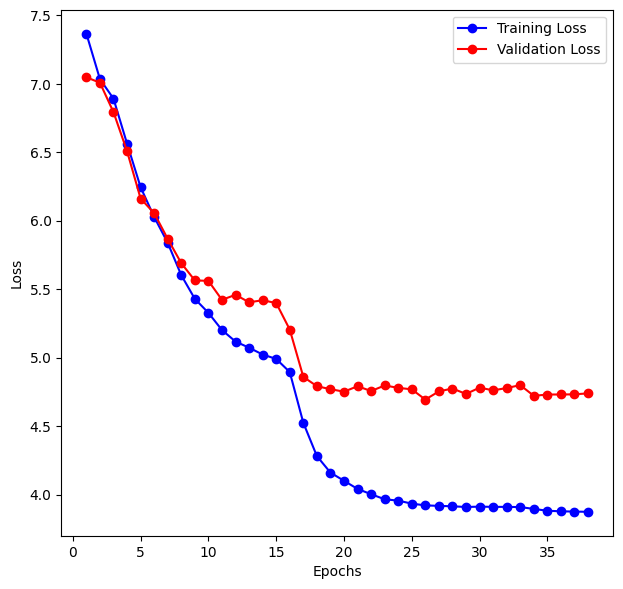

In [29]:
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)
visualize_learning_curves(epochs,train_loss,val_loss)

# K-Fold cross validation - Sagittal Subset

In [53]:
params
params['normalization'] =  'groupnorm'

In [56]:
def subset_cross_validation(subset_dir, test_subjects,fold_idx, n_folds):
    tfrecords_paths = create_subject_tfrpaths(subset_dir,test_subjects)
    #subject_paths_array = np.array(subject_paths)

    # perform cross-validation
    kf = KFold(n_splits=n_folds)
    folds = list(kf.split(tfrecords_paths))

    # get the current fold data
    train_indices, val_indices = folds[fold_idx]
    train_paths = [tfrecords_paths[i] for i in train_indices]
    val_paths = [tfrecords_paths[i] for i in val_indices]

    return train_paths, val_paths

def train_fold(fold_idx, n_folds, params, tfrecords_dir, test_subjects, batch_size, seed):
    data_dir = data_dir = os.path.join(tfrecords_dir,params['subset'])
    logs_and_model_path = refactor_path(os.path.join(logs_dir,params['interpolation'],params['subset']))
    test_paths = parse_test_tfrecords(data_dir, test_subjects[params['subset']])
    
    train_paths, val_paths = subset_cross_validation(data_dir, test_subjects[params['subset']], fold_idx, n_folds)
    
    normalization_params_train = get_norm_params(train_paths,0)
    print(f"Fold {fold_idx + 1}/{n_folds}")
    print("Number of training tuple paths:", len(train_paths))
    print("Number of validation tuple paths:", len(val_paths))
    print("Number of test tuple paths:", len(test_paths))
    print("Normalization parameters training:", normalization_params_train)
    print("Layer Normalization: ", params['normalization'])
    
    params['total_train_samples'] = len(train_paths)
    params['total_val_samples'] = len(val_paths)
    
    train_d = train_tfr_fn(train_paths, normalization_params_train, 0, batch_size, seed, params)
    val_ds = val_tfr_fn(val_paths, normalization_params_train, batch_size)
    
    training_session_path = f'Sigma3/GroupNorm/cross_validation/unet3d-GN_fold_{fold_idx + 1}_{datetime.datetime.now().strftime("(%Y-%m-%d)/%H.%M.%S")}'
    file_path, callbacks_list = prepareCallbacks(training_session_path, logs_and_model_path)
    
    features = tf.keras.layers.Input(shape=input_shape[params['subset']])
    output = unet3d_mod(yshape[params['subset']][-1], params['mode'], features, params['normalization'])
    unet3d_model = tf.keras.Model(inputs=features, outputs=output)
    unet3d_model.compile(optimizer=Adam(learning_rate=params['lr']),
                         loss=make_loss, 
                         metrics=['accuracy', eval_dice])
    
    history = unet3d_model.fit(
        train_d,
        epochs=100,
        validation_data=val_ds, 
        callbacks=callbacks_list
    )    
    return history

In [57]:
def run_kfold_cross_val(n_folds, params, resampled_dir, test_subjects,batch_size,seed):
    history_reg = []
    for fold_id in range(n_folds):
        # fold_idx, n_folds, params, log_and_model_path, resampled_dir, test_subjects, batch_size, seed
        history = train_fold(fold_id,n_folds, params, resampled_dir, test_subjects, batch_size, seed)
        history_reg.append(history)
    return history_reg

In [58]:
histories = run_kfold_cross_val(n_folds,params,tfrecords_dir,test_subjects,batch_size,seed)

Fold 1/5
Number of training tuple paths: 276
Number of validation tuple paths: 69
Number of test tuple paths: 84
Normalization parameters training: (0.0, 3963.4688)
Layer Normalization:  groupnorm
Epoch 1/100
    138/Unknown - 116s 702ms/step - loss: 7.7649 - accuracy: 0.9151 - eval_dice: 0.3417
Epoch 1: val_loss improved from inf to 7.15643, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupNorm/cross_validation/unet3d-GN_fold_1_(2024-06-22)/11.04.14\cp.ckpt
138/138 [==============================] - 129s 793ms/step - loss: 7.7649 - accuracy: 0.9151 - eval_dice: 0.3417 - val_loss: 7.1564 - val_accuracy: 0.9988 - val_eval_dice: 0.0969 - lr: 1.0000e-04
Epoch 2/100
138/138 [==============================] - ETA: 0s - loss: 7.0644 - accuracy: 0.9978 - eval_dice: 0.0593
Epoch 2: val_loss improved from 7.15643 to 6.98430, saving model to C:/Users/Eduardo/Desktop/dataortho_edu/logs/Linear Interpolation/DATASET_SAGITTAL/Sigma3/GroupN

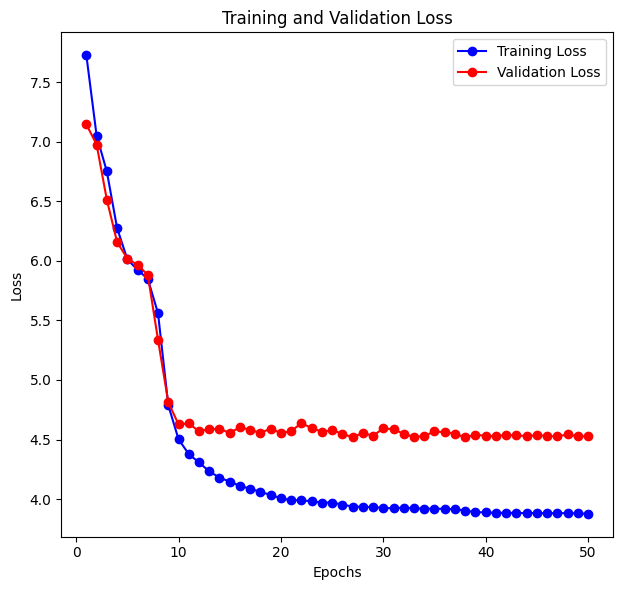

In [44]:
history_dict = histories[4].history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)
visualize_learning_curves(epochs,train_loss,val_loss)

In [30]:
def _normalization(inputs, name, mode):
    training = mode == tf.estimator.ModeKeys.TRAIN
    if name == 'instancenorm':
        return tf.keras.layers.LayerNormalization(
            axis=[1, 2, 3],  # Normalizing across the spatial dimensions
            center=True,
            scale=True,
            epsilon=1e-6)(inputs)

    if name == 'groupnorm':
        return tfa.layers.GroupNormalization(
            groups=16,
            axis=-1,  # Channel axis
            epsilon=1e-5)(inputs)

    if name == 'batchnorm':
        return tf.keras.layers.BatchNormalization(axis=-1, #channels index is the last one
                                                  trainable=True,
                                                  virtual_batch_size=None)(inputs, training=training)
    if name == 'none':
        return inputs

    raise ValueError('Invalid normalization layer')

def _activation(out, activation):
    if activation == 'relu':
        return tf.keras.layers.ReLU()(out)
    if activation == 'leaky_relu':
        return tf.keras.layers.LeakyReLU(alpha=0.01)(out)
    if activation == 'sigmoid':
        return tf.keras.layers.Activation('sigmoid')(out)
    if activation == 'softmax':
        return tf.keras.layers.Activation('softmax')(out)
    if activation == 'none':
        return out

    raise ValueError("Unknown activation {}".format(activation))

def convolution(inputs,  
                out_channels,
                kernel_size=3,
                stride=1,
                mode=tf.estimator.ModeKeys.TRAIN,
                normalization='batchnorm',
                activation='relu',
                transpose=False):

    if transpose:
        conv = tf.keras.layers.Conv3DTranspose
    else:
        conv = tf.keras.layers.Conv3D
    regularizer = None #tf.keras.regularizers.l2(1e-5) # trying L2 Regularization

    use_bias = normalization == "none"
    inputs = conv(filters=out_channels,
                  kernel_size=kernel_size,
                  strides=stride,
                  activation=None,
                  padding='same',
                  data_format='channels_last',
                  kernel_initializer=tf.compat.v1.initializers.he_uniform(), # use HE with ReLU
                  kernel_regularizer=regularizer,
                  bias_initializer='zeros',
                  bias_regularizer=regularizer,
                  use_bias=use_bias)(inputs)
    
    # batch normalization before each activation
    inputs = _normalization(inputs, normalization, mode)
    return _activation(inputs, activation)

def input_block(inputs, out_channels, normalization, mode):
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    return inputs

def downsample_block(inputs, out_channels, normalization, mode):
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode, stride=2)
    return convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)

def upsample_block(inputs, skip_connection, out_channels, normalization, mode):
    inputs = convolution(inputs, kernel_size=3, out_channels=out_channels, stride=2,
                         normalization='none', activation='none', transpose=True)

    inputs = tf.keras.layers.Concatenate(axis=-1)([inputs, skip_connection])
    
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    inputs = convolution(inputs, out_channels=out_channels, normalization=normalization, mode=mode)
    return inputs

def output_layer(inputs, out_channels, activation):
    return convolution(inputs, out_channels=out_channels, kernel_size=3, normalization='none', activation=activation)

def unet3d_mod(n_classes, mode, features, normalization='none'):

    skip_1 = input_block(inputs=features,
                         out_channels=16,
                         normalization=normalization,
                         mode=mode)

    skip_2 = downsample_block(inputs=skip_1,
                              out_channels=32,
                              normalization=normalization,
                              mode=mode)

    skip_3 = downsample_block(inputs=skip_2,
                              out_channels=64,
                              normalization=normalization,
                              mode=mode)

    skip_4 = downsample_block(inputs=skip_3,
                              out_channels=128,
                              normalization=normalization,
                              mode=mode)
    # Bridge
    out = downsample_block(inputs=skip_4,
                           out_channels=512,
                           normalization=normalization,
                           mode=mode)

    out = tf.keras.layers.Dropout(0.5)(out)

    out = upsample_block(out, skip_4,
                         out_channels=128,
                         normalization=normalization,
                         mode=mode)

    out = upsample_block(out, skip_3,
                         out_channels=64,
                         normalization=normalization,
                         mode=mode)

    out = upsample_block(out, skip_2,
                         out_channels=32,
                         normalization=normalization,
                         mode=mode)

    out = upsample_block(out, skip_1,
                         out_channels=16,
                         normalization=normalization,
                         mode=mode)

    return output_layer(out,
                        out_channels=n_classes,
                        activation='softmax')

# Example usage
inputs = tf.keras.Input(shape=(32, 256, 256, 1))
model = tf.keras.Model(inputs, unet3d_mod(n_classes=5, mode=tf.estimator.ModeKeys.TRAIN, features=inputs, normalization='batchnorm'))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d_38 (Conv3D)             (None, 32, 256, 256  432         ['input_3[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 256, 256  64         ['conv3d_38[0][0]']              
 alization)                     , 16)                                                         